# Sheet 8

Handed in by Benny Bauer and Anton Schwarz

In [1]:
import os
import numpy as np
import torch
from torch import nn
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

## 1) Anomaly detection for Autoencoders

Setup: we save computation-heavy data so we do not have to recompute multiple times when analysing. Should the notebook not run properly, set all of thes values to `False`.

In [52]:
# Whether to freshly download data
DOWNLOAD_DATA = False
# whether to preprocess
ALREADY_PREPROCESSED = True
# whether to load an existing model (or train a new one)
LOAD_EXISTING_MODEL = False
# preprocessed data locations

# model saving locations
MLP_AUTOENCODER_MODEL_SAVE_PATH = 'data08/mlp_autoencoder_model.pth'
CNN_AUTOENCODER_MODEL_SAVE_PATH = 'data08/cnn_autoencoder_model.pth'
CNN_QCD_AUTOENCODER_MODEL_SAVE_PATH = 'data08/mlp_qcd_autoencoder_model.pth'

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [5]:
def optionally_save_model(model, savepath):
    if not LOAD_EXISTING_MODEL:
        save_model = input("Save model? (y/n) ")
        if save_model == "y":
            # save model
            print(f"Saving model as {savepath}")
            torch.save(model.state_dict(), savepath)
        else:
            print("Not saving model")
    else:
        print("Not saving model that was previously loaded")

In [6]:
def load_model(model, savepath):
    if not os.path.exists(savepath):
        raise ValueError(f"Model not found at {savepath}, consider retraining.")
    print(f"Loading existing model from {savepath}")
    model.load_state_dict(torch.load(savepath))
    print("Model loaded.")

## Preparations

### Load Data (Skip if already preprocessed)

In [6]:
# download data to folder data04
# this might take some time (50MB)
# you can also do this manually (download + unpack zip)
import wget
from zipfile import ZipFile
from tqdm import tqdm

if DOWNLOAD_DATA:
    DESTINATION = "data06"
    url = "https://www.thphys.uni-heidelberg.de/~plehn/pics/"
    filename = "toptagging-short.zip"
    url = url + filename

    os.makedirs(DESTINATION, exist_ok=True)
    os.chdir(DESTINATION)
    wget.download(url, filename)
    with ZipFile(filename, "r") as zip_ref:
        for file in tqdm(iterable=zip_ref.namelist(), total=len(zip_ref.namelist())):
            zip_ref.extract(member=file)
    os.chdir("..")
else:
    print("Skipping download, using existing data")

Skipping download, using existing data


In [7]:
if not ALREADY_PREPROCESSED:
    # load data
    X_train = np.load( "data06/toptagging-short/x_train_short.npy")
    y_train = np.load( "data06/toptagging-short/y_train_short.npy")
    X_test = np.load( "data06/toptagging-short/x_test_short.npy")
    y_test = np.load( "data06/toptagging-short/y_test_short.npy")
    X_val = np.load( "data06/toptagging-short/x_val_short.npy")
    y_val = np.load( "data06/toptagging-short/y_val_short.npy")

    print(f"train data shape: {X_train.shape}")
    print(f"train labels shape: {y_train.shape}")
    print(f"test data shape: {X_test.shape}")
    print(f"test labels shape: {y_test.shape}")
    print(f"val data shape: {X_val.shape}")
    print(f"val labels shape: {y_val.shape}")
else:
    print("Data is already preprocessed, skipping preprocessing")

train data shape: (30000, 200, 4)
train labels shape: (30000,)
test data shape: (30000, 200, 4)
test labels shape: (30000,)
val data shape: (30000, 200, 4)
val labels shape: (30000,)


### Physics bit (Skip if already preprocessed)

In [8]:
# Some initial settings
__n_warning__ = 0.7
n_shift_phi, n_shift_eta = 0, 0

# Grid settings
xpixels = np.arange(-2.6, 2.6, 0.029)
ypixels = np.arange(-np.pi, np.pi, 0.035)

# Calculate the pseudorapidity of pixel entries
def eta (pT, pz):
    small = 1e-10
    small_pT = (np.abs(pT) < small)
    small_pz = (np.abs(pz) < small)
    not_small = ~(small_pT | small_pz)
    theta = np.arctan(pT[not_small]/pz[not_small])
    theta[theta < 0] += np.pi
    etas = np.zeros_like(pT)
    etas[small_pz] = 0
    etas[small_pT] = 1e-10
    etas[not_small] = np.log(np.tan(theta/2))
    return etas

# Calculate the azimuthal angle of pixel entries
def phi (px, py):
    """
    phis are returned in rad., np.arctan(0,0)=0 -> zero constituents set to -np.pi
    """
    phis = np.arctan2(py,px)
    phis[phis < 0] += 2*np.pi
    phis[phis > 2*np.pi] -= 2*np.pi
    phis = phis - np.pi 
    return phis

# function to calculate masses
def mass (E,px,py,pz):
    mass = np.sqrt(np.maximum(0.,E**2-px**2-py**2-pz**2))
    return mass

# function to return the image momenta for centroid and principal axis
def img_mom (x, y, weights, x_power, y_power):
    return ((x**x_power)*(y**y_power)*weights).sum()

# returns the jet image
def orig_image (etas, phis, es):
    """
    Gives the value on grid with minimal distance,
    eg. for xpixel = (0,1,2,3,..) eta=1.3 -> xpixel=1, eta=1.6 ->xpixel=2
    """
    z = np.zeros((etas.shape[0],len(xpixels),len(ypixels)))
    in_grid = ~((etas < xpixels[0]) | (etas > xpixels[-1]) | (phis < ypixels[0]) | (phis > ypixels[-1]))
    xcoords = np.argmin(np.abs(etas[:,None,:] - xpixels[None,:,None]),axis=1)
    ycoords = np.argmin(np.abs(phis[:,None,:] - ypixels[None,:,None]),axis=1)
    ncoords = np.repeat(np.arange(etas.shape[0])[:,None],etas.shape[1],axis=1)
    z[ncoords[in_grid],ycoords[in_grid],xcoords[in_grid]] = es[in_grid]
    return z

# preprocess the jet
def preprocessing( x ,y, weights, rotate=True, flip=True ):
    """
    (x,y) are the coordinates and weights the corresponding values, shifts
    centroid to origin, rotates image, so that principal axis is vertical,
    flips image, so that most weights lay in (x<0, y>0)-plane.
    Method for calculating principal axis (similar to tensor of inertia):
    https://en.wikipedia.org/wiki/Image_moment
    here: y=phi, phi has modulo 2*np.pi but it's not been taken care of hear,
    so possible issues with calculating the centroid
    -> pre-shifting of events outside of this function solves the problem
    for iamge-data with Delta_phi < 2*np.pi
    """

    # Shift
    x_centroid = img_mom(x, y, weights, 1, 0) / weights.sum()
    y_centroid = img_mom(x, y, weights, 0, 1)/ weights.sum()
    x = x - x_centroid
    y = y - y_centroid

    # Check if shifting worked, there can be problems with modulo variables like phi (y)
    # x and y are sorted after highest weight, 0-comp. gives hottest event
    # for Jet-like Images Centroid should be close to hottest constituen (pT-sorted arrays)  
    global n_shift_phi
    global n_shift_eta
    if np.abs(x[0]) > __n_warning__:
        n_shift_eta += 1  
    if np.abs(y[0]) > __n_warning__:
        n_shift_phi += 1       

    if rotate:
        #Ccovariant matrix, eigenvectors corr. to principal axis
        u11 = img_mom(x, y, weights, 1, 1) / weights.sum()
        u20 = img_mom(x, y, weights, 2, 0) / weights.sum()
        u02 = img_mom(x, y, weights, 0, 2) / weights.sum()
        cov = np.array([[u20, u11], [u11, u02]])

        # Eigenvalues and eigenvectors of covariant matrix
        evals, evecs = np.linalg.eig(cov)

        # Sorts the eigenvalues, v1, [::-1] turns array around, 
        sort_indices = np.argsort(evals)[::-1]
        e_1 = evecs[:, sort_indices[0]]  # Eigenvector with largest eigenvalue
        e_2 = evecs[:, sort_indices[1]]

        # Theta to x_asix, arctan2 gives correct angle
        theta = np.arctan2(e_1[0], e_1[1])
  
        # Rotation, so that princple axis is vertical
        # anti-clockwise rotation matrix
        rotation = np.matrix([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
        transformed_mat = rotation * np.stack([x,y])
        x_rot, y_rot = transformed_mat.A
    else: 
        x_rot, y_rot = x, y
  
    # Flipping
    n_flips = 0
    if flip:
        if weights[x_rot<0.].sum() < weights[x_rot>0.].sum():
            x_rot = -x_rot
            n_flips  += 1
        if weights[y_rot<0.].sum() > weights[y_rot>0.].sum():
            y_rot = -y_rot
            n_flips += 1
            
    return x_rot, y_rot


# function to convert the jet to an image
def constit_to_img( jets, n_constit, norm, rotate, flip ):
    
    print( "Crop constituents" )
    jets = jets[:,0:n_constit,:]
    
    print( "Calculating pT" )
    E     = jets[:,:,0]
    pxs   = jets[:,:,1]
    pys   = jets[:,:,2]
    pzs   = jets[:,:,3]
    pT    = np.sqrt(pxs**2+pys**2)
    
    print( "Calculating eta" )
    etas  = eta(pT,pzs)
    
    print( "Calculating phi" )
    phis  = phi(pxs,pys)
    
    print( "Calculating the mass" )
    E_tot = E.sum(axis=1)
    px_tot = pxs.sum(axis=1)
    py_tot = pys.sum(axis=1)
    pz_tot = pzs.sum(axis=1)
    j_mass = mass(E_tot, px_tot, py_tot, pz_tot)
    
    print( "Pre-shifting the phis" )
    phis = (phis.T - phis[:,0]).T
    phis[phis < -np.pi] += 2*np.pi
    phis[phis > np.pi] -= 2*np.pi
    
    print( "Using pT as weight" )
    weights = pT
    
    print( "Preprocessing" )
    
    for i in range( np.shape(etas)[0] ):
        etas[i,:], phis[i,:] = preprocessing( etas[i,:], phis[i,:], weights[i,:], rotate, flip )
    
    print( "Creating images" )
    z_ori = orig_image(etas, phis, weights)
    
    #return z_ori
        
    print( "Cropping and normalising" )
    n_crop = 40
    z_new = np.zeros( (z_ori.shape[0],n_crop, n_crop) )
    for i in range(z_ori.shape[0]):
        Npix = z_ori[i,:,:].shape
        z_new[i,:,:] = z_ori[i, int(Npix[0]/2-n_crop/2) : int(Npix[0]/2+n_crop/2), int(Npix[1]/2-n_crop/2) : int(Npix[1]/2+n_crop/2) ]
        if norm:
            z_sum = z_new[i,:,:].sum()
            if z_sum != 0.:
                z_new[i,:,:] = z_new[i,:,:]/z_sum
    
    print( "Reshaping" )
    z_out = z_new.reshape( (z_new.shape[0],-1) ).reshape(-1, 1, 40,40)
    
    return z_out

In [9]:
if not ALREADY_PREPROCESSED:
    z_train = constit_to_img( X_train, 50, True, True, True )
    z_val = constit_to_img( X_val, 50, True, True, True )
    z_test = constit_to_img( X_test, 50, True, True, True )
else:
    print("Data is already preprocessed, skipping preprocessing")

Crop constituents
Calculating pT
Calculating eta
Calculating phi
Calculating the mass
Pre-shifting the phis
Using pT as weight
Preprocessing
Creating images
Cropping and normalising
Reshaping
Crop constituents
Calculating pT
Calculating eta
Calculating phi
Calculating the mass
Pre-shifting the phis
Using pT as weight
Preprocessing
Creating images
Cropping and normalising
Reshaping
Crop constituents
Calculating pT
Calculating eta
Calculating phi
Calculating the mass
Pre-shifting the phis
Using pT as weight
Preprocessing
Creating images
Cropping and normalising
Reshaping


In [10]:
if not ALREADY_PREPROCESSED:
    os.makedirs("data08", exist_ok=True)
    np.save("data08/z_train.npy", z_train)
    np.save("data08/z_val.npy", z_val)
    np.save("data08/z_test.npy", z_test)
else:
    print("Data is already preprocessed, do not save")

### Load Preprocessed Data

In [9]:
if ALREADY_PREPROCESSED:
    z_train = np.load("data08/z_train.npy")
    z_val = np.load("data08/z_val.npy")
    z_test = np.load("data08/z_test.npy")

    y_train = np.load( "data06/toptagging-short/y_train_short.npy")
    y_test = np.load( "data06/toptagging-short/y_test_short.npy")
    y_val = np.load( "data06/toptagging-short/y_val_short.npy")
else:
    print("Data is not preprocessed, skipping loading")

### Dataloaders

In [10]:
# dataset
class Jet_Dataset(torch.utils.data.Dataset):
    # no preprocessing needed (i.e. no unsqueeze) to get layers dim
    def __init__(self, data, labels):
        self.data = torch.tensor(data).to(torch.float32)
        self.labels = torch.tensor(labels).to(torch.float32)
        self.length = len(data)

    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

Note that the data in `z_train` is shaped as $(n_{\textrm{batches}}, n_{\textrm{channels}}, n_x, n_y)$. We have one channel and the image dimensions are $40\times40$.

The linear layers within the MLP will only act on the last dimension of the datastructure. Hence we must reshape the array to shape $(n_{\textrm{batches}}, n_x\times n_y)$.

In [11]:
def reshape_data(x):
    return x.reshape(x.shape[:1] + (-1,))

In [12]:
z_train_reshaped = reshape_data(z_train)
only_qcd = torch.utils.data.DataLoader(
    Jet_Dataset(z_train_reshaped[y_train == 0], y_train[y_train == 0]),
    batch_size=64,
    shuffle=True,
)
only_top = torch.utils.data.DataLoader(
    Jet_Dataset(z_train_reshaped[y_train == 1], y_train[y_train == 1]),
    batch_size=64,
    shuffle=True,
)

In [13]:
only_cnn_qcd = torch.utils.data.DataLoader(
    Jet_Dataset(z_train[y_train == 0], y_train[y_train == 0]),
    batch_size=64,
    shuffle=True,
)
only_cnn_top = torch.utils.data.DataLoader(
    Jet_Dataset(z_train[y_train == 1], y_train[y_train == 1]),
    batch_size=64,
    shuffle=True,
)

In [14]:
next(iter(only_cnn_qcd))[1].shape

torch.Size([64])

## (a)
Autoencoder

In [15]:
# TODO: Construct autoencoder
class Jet_Autoencoder(nn.Module):
    def __init__(self, input_dim, bottleneck_dim, hidden_dim):
        super(Jet_Autoencoder, self).__init__()
        self.input_dim = input_dim
        self.bottleneck_dim = bottleneck_dim
        self.hidden_dim = hidden_dim
        # encoder: MLP with 2 hidden layers
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, bottleneck_dim)
        )
        # decoder: MLP with 2 hidden layers
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x):
        # encode, decode
        x = self.encoder(x)
        x = self.decoder(x)
        return x

## (b)
Train autoencoder on QCD jets only

In [16]:
image_size = 40 * 40

In [55]:
def batch_image_loss(model, x, loss_fn):
    x = x.to(device)
    xnew = model(x)
    return loss_fn(x, xnew)

In [56]:
def train_autoencoder_epoch(model, dataloader, losses, batch_loss_fn, loss_fn, optimizer):
    # run for each epoch (and ran over all data)
    for x, y in dataloader:
        # loading in batches of batchsize
        optimizer.zero_grad()
        loss = batch_loss_fn(model, x, loss_fn)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return losses

In [57]:
def plot_training_loss(losses, epoch: int):
    plt.plot(losses)
    plt.yscale("log")
    plt.title(f"Training loss after {epoch} epochs")
    plt.xlabel("Batch")
    plt.ylabel("Loss");

In [19]:
# TODO: Train autoencoder on QCD jets
# Choose the bottleneck dimension between 5 and 20
# model
model = Jet_Autoencoder(
    input_dim=image_size,
    bottleneck_dim=10,
    hidden_dim=100
)
model = model.to(device)
print(f"The model has {sum(p.numel() for p in model.parameters() if p.requires_grad):,} trainable parameters")

if not LOAD_EXISTING_MODEL:
    # train model
    model.train()

    # loss function
    loss_fn = nn.MSELoss()

    # optimiser
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    # training
    n_epochs = 100
    train_losses = []
    for epoch in tqdm(range(n_epochs)):
        train_losses = train_autoencoder_epoch(
            model,
            only_qcd,
            train_losses,
            batch_image_loss,
            loss_fn,
            optimizer
        )

    plot_training_loss(train_losses, n_epochs)
    # ask for user input to save model
else:
    load_model(model, MLP_AUTOENCODER_MODEL_SAVE_PATH)

The model has 344,010 trainable parameters
Loading existing model from data08/mlp_autoencoder_model.pth
Model loaded.


In [20]:
optionally_save_model(model, MLP_AUTOENCODER_MODEL_SAVE_PATH)

Not saving model that was previously loaded


## (c)

In [21]:
# TODO: Visualize original vs reconstructed QCD and top jets
model.eval()
qcd_samples = torch.Tensor(z_train_reshaped[y_train == 0])
qcd_samples = qcd_samples.to(device)
qcd_reconstruction = model(qcd_samples).reshape(-1, 40, 40)
qcd_samples = qcd_samples.reshape(-1, 40, 40)

top_samples = torch.Tensor(z_train_reshaped[y_train == 1])
top_samples = top_samples.to(device)
top_reconstruction = model(top_samples).reshape(-1, 40, 40)
top_samples = top_samples.reshape(-1, 40, 40)

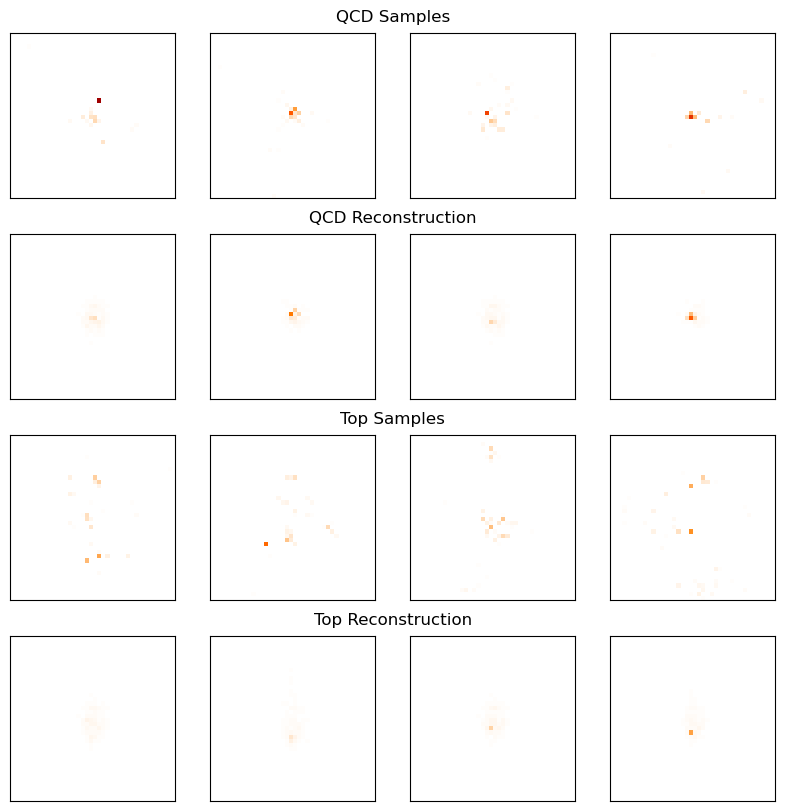

In [22]:
# Create a figure
fig = plt.figure(constrained_layout=True, figsize=(8, 8))

# Create subfigures
subfigs = fig.subfigures(4, 1)

vmin, vmax = 0, qcd_samples.max()
# Add data to the subfigures
for subfig, data, title in zip(
    subfigs.flatten(),
    [qcd_samples, qcd_reconstruction, top_samples, top_reconstruction],
    ["QCD Samples", "QCD Reconstruction", "Top Samples", "Top Reconstruction"],
):
    axes = subfig.subplots(1, 4)
    subfig.suptitle(title)
    for i, ax in enumerate(axes):
        ax.imshow(data[i].detach().cpu(), vmin=0, vmax=vmax, cmap="gist_heat_r")
        ax.set_xticks([])
        ax.set_yticks([])

plt.show()

### Discussion:
The QCD reconstructions take over the structure of the QCD samples, while the top reconstructions do not seem to be related to the top samples. They do not replicate the structure of the original sample.

This is because the network was trained exclusively on QCD images and is specialised in reproducing the structure of QCD jet images. In contrast, top jet images are unknown and it does not know how to compress the structure.

## (d)

### Visualise MSE

In [23]:
# TODO: Visualize pixel-wise MSE, plot ROC
qcd_mse = torch.mean((qcd_samples - qcd_reconstruction)**2, dim=(1, 2))
top_mse = torch.mean((top_samples - top_reconstruction)**2, dim=(1, 2))

Text(0.5, 1.0, 'MSE of Reconstruction: Comparison between QCD and Top Jets')

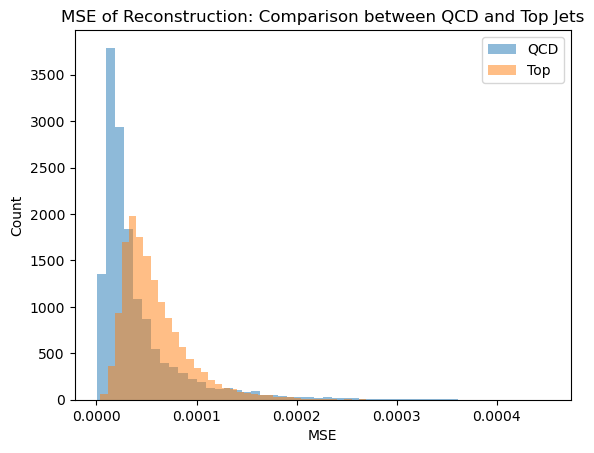

In [24]:
plt.hist(qcd_mse.detach().cpu(), bins=50, alpha=0.5, label="QCD");
plt.hist(top_mse.detach().cpu(), bins=50, alpha=0.5, label="Top");
plt.legend();
plt.xlabel("MSE")
plt.ylabel("Count")
plt.title("MSE of Reconstruction: Comparison between QCD and Top Jets")

As can be immediately seen from the histogram, the MSE of QCD reconstructions generally is lower than that of top reconstructions. This is underlined by the different AUC values. The AUC of the QCD reconstruction MSE is lower than that of top reconstructions. We can deduce that the reconstructions of QCD type jets are better when using this model, which is trained on QCD jets. 

In [25]:
def pixelwise_mse(samples, reconstruction, amount=4):
    return torch.mean((samples[:amount] - reconstruction[:amount])**2, dim=0).detach().cpu()

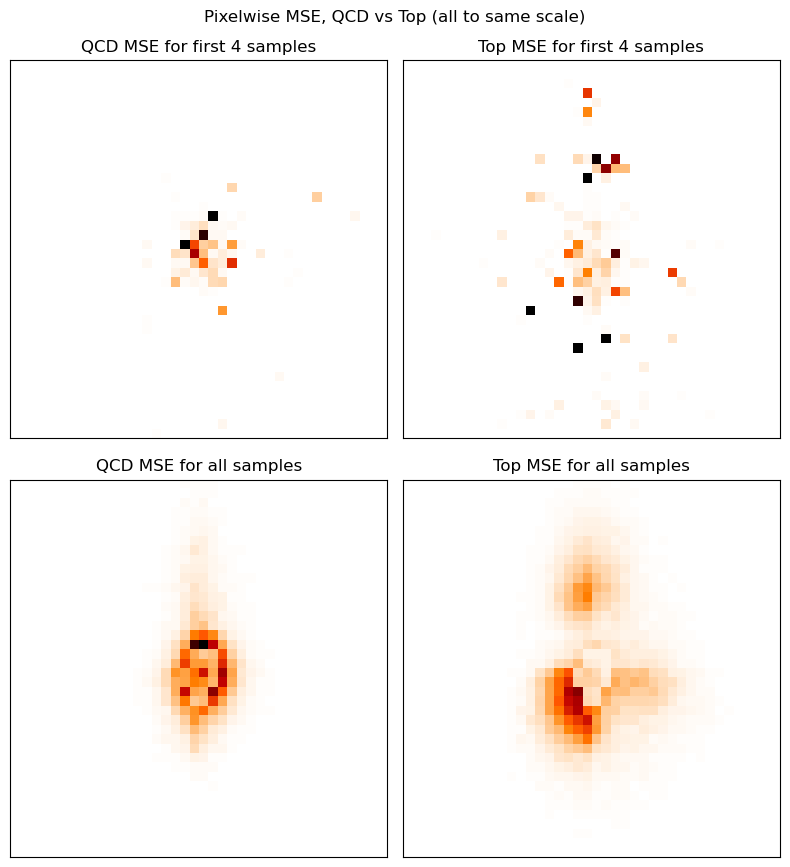

In [26]:
fig, axes = plt.subplots(2, 2, figsize=(8, 9))
vmin = 0
vmax = torch.stack(
    [
        pixelwise_mse(qcd_samples, qcd_reconstruction, -1),
        pixelwise_mse(top_samples, top_reconstruction, -1)]
    ).max()
axes[0, 0].imshow(
    pixelwise_mse(qcd_samples, qcd_reconstruction),
    vmin=vmin,
    vmax=vmax,
    cmap="gist_heat_r"
)
axes[0, 0].set_title("QCD MSE for first 4 samples")
axes[0, 1].imshow(
    pixelwise_mse(top_samples, top_reconstruction),
    vmin=vmin,
    vmax=vmax,
    cmap="gist_heat_r"
)
axes[0, 1].set_title("Top MSE for first 4 samples")
axes[1, 0].imshow(
    pixelwise_mse(qcd_samples, qcd_reconstruction, amount=-1),
    vmin=vmin,
    vmax=vmax,
    cmap="gist_heat_r"
)
axes[1, 0].set_title("QCD MSE for all samples")
axes[1, 1].imshow(
    pixelwise_mse(top_samples, top_reconstruction, amount=-1),
    vmin=vmin,
    vmax=vmax,
    cmap="gist_heat_r"
)
axes[1, 1].set_title("Top MSE for all samples")

for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

plt.suptitle("Pixelwise MSE, QCD vs Top (all to same scale)")
plt.tight_layout()

### Plot ROC
Using the TEST dataset

In [27]:
z_test_reshaped = torch.Tensor(reshape_data(z_test)).to(device)

We do not use a dataloader since it all works fine within memory and we do not need to batch.

In [28]:
y_test_reconstruction = model(z_test_reshaped)
y_test_mse = torch.mean((z_test_reshaped - y_test_reconstruction)**2, dim=1)
y_test_mse = y_test_mse.detach().cpu().numpy()

In [29]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_mse)
auc_score = roc_auc_score(y_test, y_test_mse)

THe "true" class is the top class (with label = 1). This makes sense since we want to tag anomalies.

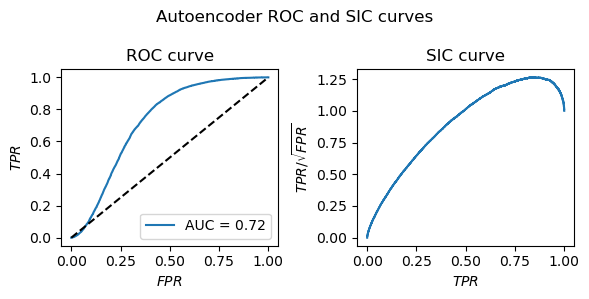

In [30]:
# create figure and two subplots
fig, ax = plt.subplots(1, 2, figsize=(6, 3))

# plot ROC curve
ax[0].plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
ax[0].plot([0, 1], [0, 1], "--", color="black")
ax[0].set_title("ROC curve")
ax[0].set_xlabel("$FPR$")
ax[0].set_ylabel("$TPR$")
ax[0].legend(loc='lower right')

# plot SIC curve
ax[1].plot(tpr[fpr != 0], tpr[fpr != 0]/np.sqrt(fpr[fpr != 0]))
ax[1].set_title("SIC curve")
ax[1].set_xlabel("$TPR$")
ax[1].set_ylabel("$TPR/\sqrt{{FPR}}$")

plt.suptitle("Autoencoder ROC and SIC curves")

plt.tight_layout()
plt.show()

## (e)
Repeat for CNN

In [53]:
# TODO: Repeat everything for CNN
class Jet_CNN_Autoencoder(nn.Module):
    def __init__(self, input_dim, bottleneck_dim, hidden_dim):
        super(Jet_CNN_Autoencoder, self).__init__()
        self.input_dim = input_dim
        self.bottleneck_dim = bottleneck_dim
        self.hidden_dim = hidden_dim
        # encoder: CNN with 2 convolutional layers
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.Dropout2d(0.2),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.Dropout2d(0.2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32*10*10, bottleneck_dim)  # or LazyLinear
        )
        # decoder: CNN with 2 convolutional layers
        # use nn.ConvTranspose2d for upsampling (to get back original dimensions)
        # see https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_dim, 32*10*10),
            nn.Unflatten(1, (32, 10, 10)),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
        )

    def forward(self, x):
        # encode, decode
        x = self.encoder(x)
        x = self.decoder(x)
        return x

The model has 76,779 trainable parameters


100%|██████████| 100/100 [06:00<00:00,  3.60s/it]


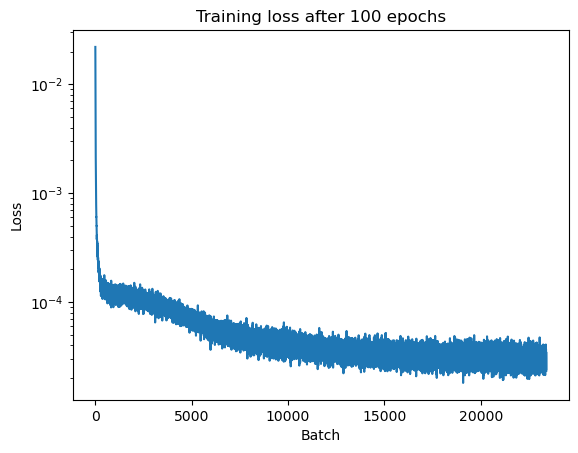

In [58]:
modelCNN = Jet_CNN_Autoencoder(
    input_dim=image_size,
    bottleneck_dim=10,
    hidden_dim=100
)
modelCNN = modelCNN.to(device)
print(f"The model has {sum(p.numel() for p in modelCNN.parameters() if p.requires_grad):,} trainable parameters")

if not LOAD_EXISTING_MODEL:
    # train model
    modelCNN.train()

    # loss function
    loss_fn = nn.MSELoss()

    # optimiser
    optimizer = torch.optim.Adam(modelCNN.parameters(), lr=1e-3)

    n_epochs = 100
    train_losses = []
    for epoch in tqdm(range(n_epochs)):
        train_losses = train_autoencoder_epoch(
            modelCNN,
            only_cnn_qcd,
            train_losses,
            batch_image_loss,
            loss_fn,
            optimizer
        )
    plot_training_loss(train_losses, n_epochs)
else:
    load_model(modelCNN, CNN_AUTOENCODER_MODEL_SAVE_PATH)


In [36]:
optionally_save_model(modelCNN, CNN_AUTOENCODER_MODEL_SAVE_PATH)

Not saving model


In [34]:
# TODO: Visualize original vs reconstructed QCD and top jets
modelCNN.eval()
qcd_samples = torch.Tensor(z_train[y_train == 0])
qcd_samples = qcd_samples.to(device)
qcd_reconstruction = modelCNN(qcd_samples).reshape(-1, 40, 40)
qcd_samples = qcd_samples.reshape(-1, 40, 40)

top_samples = torch.Tensor(z_train[y_train == 1])
top_samples = top_samples.to(device)
top_reconstruction = modelCNN(top_samples).reshape(-1, 40, 40)
top_samples = top_samples.reshape(-1, 40, 40)

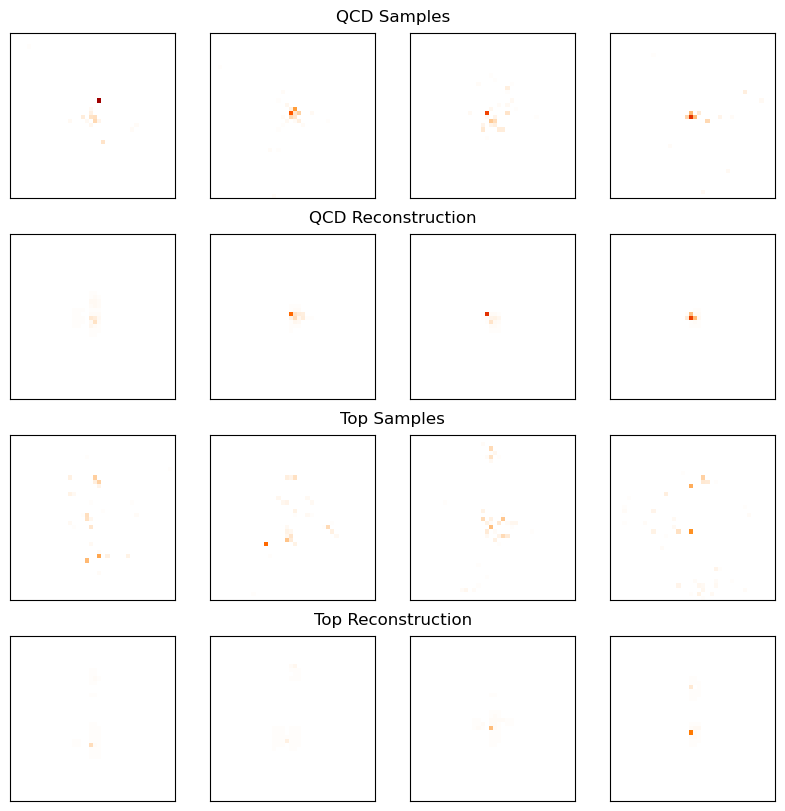

In [35]:
# Create a figure
fig = plt.figure(constrained_layout=True, figsize=(8, 8))

# Create subfigures
subfigs = fig.subfigures(4, 1)

vmin, vmax = 0, torch.cat([qcd_samples, qcd_reconstruction]).max()
# Add data to the subfigures
for subfig, data, title in zip(
    subfigs.flatten(),
    [qcd_samples, qcd_reconstruction, top_samples, top_reconstruction],
    ["QCD Samples", "QCD Reconstruction", "Top Samples", "Top Reconstruction"],
):
    axes = subfig.subplots(1, 4)
    subfig.suptitle(title)
    for i, ax in enumerate(axes):
        ax.imshow(data[i].detach().cpu(), vmin=0, vmax=vmax, cmap="gist_heat_r")
        ax.set_xticks([])
        ax.set_yticks([])

plt.show()

#### Discussion

Once again, the QCD reconstruction appears to be better than the top reconstruction.

In [36]:
# TODO: Visualize pixel-wise MSE, plot ROC
qcd_mse_cnn = torch.mean((qcd_samples - qcd_reconstruction)**2, dim=(1, 2))
top_mse_cnn = torch.mean((top_samples - top_reconstruction)**2, dim=(1, 2))

Text(0.5, 1.0, 'MSE of Reconstruction: Comparison between QCD and Top Jets')

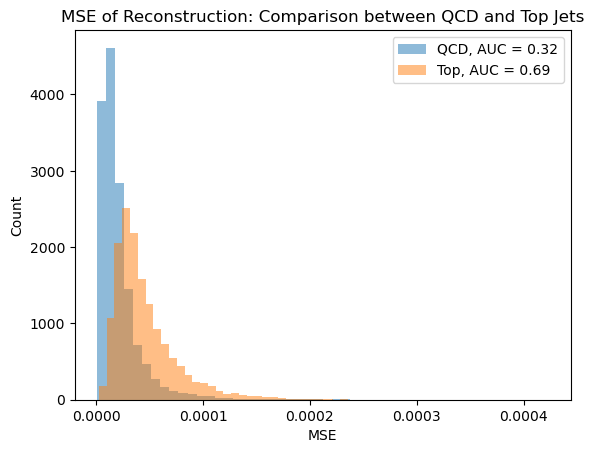

In [37]:
plt.hist(
    qcd_mse_cnn.detach().cpu(), bins=50, alpha=0.5,
    label=f"QCD, AUC = {torch.sum(qcd_mse_cnn):.2f}"
);
plt.hist(
    top_mse_cnn.detach().cpu(), bins=50, alpha=0.5,
    label=f"Top, AUC = {torch.sum(top_mse_cnn):.2f}"
);
plt.legend();
plt.xlabel("MSE")
plt.ylabel("Count")
plt.title("MSE of Reconstruction: Comparison between QCD and Top Jets")

Once more, the reconstruction is better for QCD jets. This model was trained on QCD jet data.

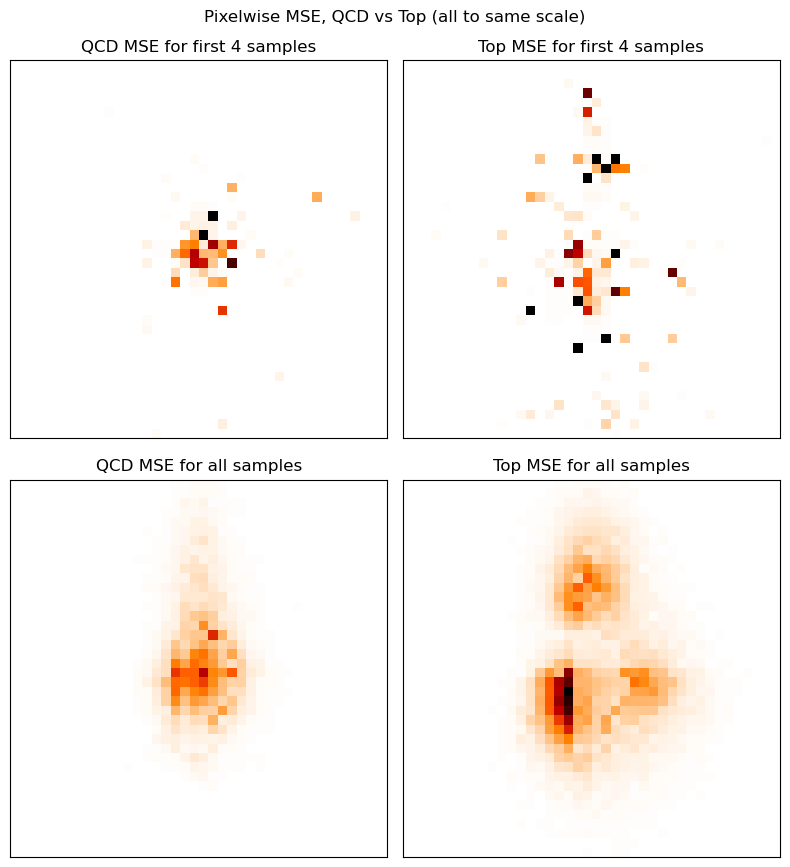

In [38]:
fig, axes = plt.subplots(2, 2, figsize=(8, 9))
vmin = 0
vmax = torch.stack(
    [
        pixelwise_mse(qcd_samples, qcd_reconstruction, -1),
        pixelwise_mse(top_samples, top_reconstruction, -1)]
    ).max()
axes[0, 0].imshow(
    pixelwise_mse(qcd_samples, qcd_reconstruction),
    vmin=vmin,
    vmax=vmax,
    cmap="gist_heat_r"
)
axes[0, 0].set_title("QCD MSE for first 4 samples")
axes[0, 1].imshow(
    pixelwise_mse(top_samples, top_reconstruction),
    vmin=vmin,
    vmax=vmax,
    cmap="gist_heat_r"
)
axes[0, 1].set_title("Top MSE for first 4 samples")
axes[1, 0].imshow(
    pixelwise_mse(qcd_samples, qcd_reconstruction, amount=-1),
    vmin=vmin,
    vmax=vmax,
    cmap="gist_heat_r"
)
axes[1, 0].set_title("QCD MSE for all samples")
axes[1, 1].imshow(
    pixelwise_mse(top_samples, top_reconstruction, amount=-1),
    vmin=vmin,
    vmax=vmax,
    cmap="gist_heat_r"
)
axes[1, 1].set_title("Top MSE for all samples")

for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

plt.suptitle("Pixelwise MSE, QCD vs Top (all to same scale)")
plt.tight_layout()

In [39]:
y_test_reconstruction = modelCNN(torch.Tensor(z_test))
y_test_mse = torch.mean(
    (torch.Tensor(z_test).squeeze() - y_test_reconstruction.squeeze())**2,
    dim=(1, 2)
)
y_test_mse = y_test_mse.detach().cpu().numpy()

In [40]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_mse)
auc_score = roc_auc_score(y_test, y_test_mse)

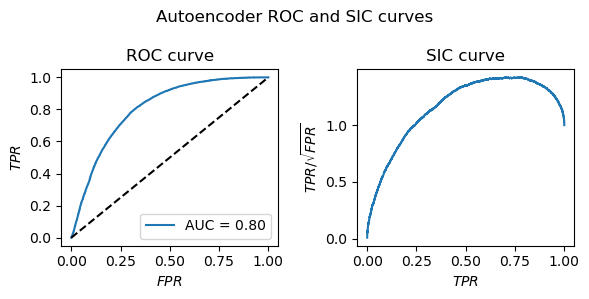

In [41]:
# create figure and two subplots
fig, ax = plt.subplots(1, 2, figsize=(6, 3))

# plot ROC curve
ax[0].plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
ax[0].plot([0, 1], [0, 1], "--", color="black")
ax[0].set_title("ROC curve")
ax[0].set_xlabel("$FPR$")
ax[0].set_ylabel("$TPR$")
ax[0].legend(loc='lower right')

# plot SIC curve
ax[1].plot(tpr[fpr != 0], tpr[fpr != 0]/np.sqrt(fpr[fpr != 0]))
ax[1].set_title("SIC curve")
ax[1].set_xlabel("$TPR$")
ax[1].set_ylabel("$TPR/\sqrt{{FPR}}$")

plt.suptitle("Autoencoder ROC and SIC curves")

plt.tight_layout()
plt.show()

### (f)

In [42]:
# TODO: Repeat everything for autoencoder trained on top jets
# You can either use a MLP or a CNN

We use the CNN model `Jet_CNN_Autoencoder` and train it only on top jets.

In [43]:
modelCNNonlytop = Jet_CNN_Autoencoder(
    input_dim=image_size,
    bottleneck_dim=10,
    hidden_dim=100
)
modelCNNonlytop = modelCNNonlytop.to(device)
print(f"The model has {sum(p.numel() for p in modelCNNonlytop.parameters() if p.requires_grad):,} trainable parameters")

if not LOAD_EXISTING_MODEL:
    # train model
    modelCNNonlytop.train()

    # loss function
    loss_fn = nn.MSELoss()

    # optimiser
    optimizer = torch.optim.Adam(modelCNNonlytop.parameters(), lr=1e-3)

    n_epochs = 100
    train_losses = []
    for epoch in tqdm(range(n_epochs)):
        train_losses = train_autoencoder_epoch(
            modelCNNonlytop,
            only_cnn_top,
            train_losses,
            batch_image_loss,
            loss_fn,
            optimizer
        )
    plot_training_loss(train_losses, n_epochs)
else:
    load_model(modelCNNonlytop, CNN_QCD_AUTOENCODER_MODEL_SAVE_PATH)

The model has 76,779 trainable parameters
Loading existing model from data08/mlp_qcd_autoencoder_model.pth
Model loaded.


In [44]:
optionally_save_model(modelCNNonlytop, CNN_QCD_AUTOENCODER_MODEL_SAVE_PATH)

Not saving model that was previously loaded


In [45]:
# TODO: Visualize original vs reconstructed QCD and top jets
modelCNNonlytop.eval()
qcd_samples = torch.Tensor(z_train[y_train == 0])
qcd_samples = qcd_samples.to(device)
qcd_reconstruction = modelCNNonlytop(qcd_samples).reshape(-1, 40, 40)
qcd_samples = qcd_samples.reshape(-1, 40, 40)

top_samples = torch.Tensor(z_train[y_train == 1])
top_samples = top_samples.to(device)
top_reconstruction = modelCNNonlytop(top_samples).reshape(-1, 40, 40)
top_samples = top_samples.reshape(-1, 40, 40)

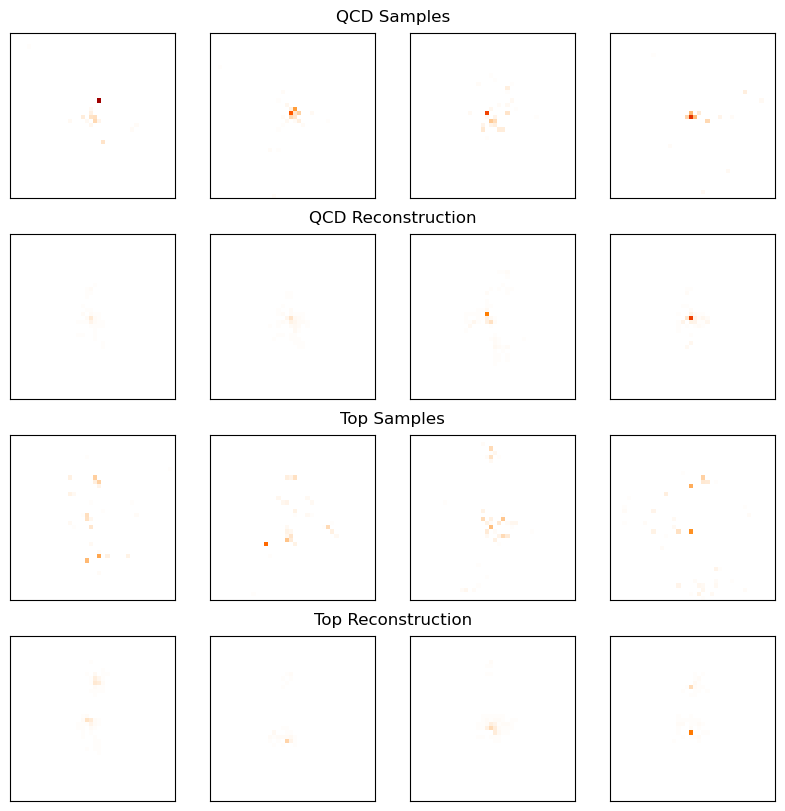

In [46]:
# Create a figure
fig = plt.figure(constrained_layout=True, figsize=(8, 8))

# Create subfigures
subfigs = fig.subfigures(4, 1)

vmin, vmax = 0, torch.cat([qcd_samples, qcd_reconstruction]).max()
# Add data to the subfigures
for subfig, data, title in zip(
    subfigs.flatten(),
    [qcd_samples, qcd_reconstruction, top_samples, top_reconstruction],
    ["QCD Samples", "QCD Reconstruction", "Top Samples", "Top Reconstruction"],
):
    axes = subfig.subplots(1, 4)
    subfig.suptitle(title)
    for i, ax in enumerate(axes):
        ax.imshow(data[i].detach().cpu(), vmin=0, vmax=vmax, cmap="gist_heat_r")
        ax.set_xticks([])
        ax.set_yticks([])

plt.show()

We see that the reconstruction of the top jets continues to fail for the most part, despite having trained only on top jets. In addition, the QCD reconstruction is noticeably worse.

In [47]:
# TODO: Visualize pixel-wise MSE, plot ROC
qcd_mse_cnn_onlytop = torch.mean((qcd_samples - qcd_reconstruction)**2, dim=(1, 2))
top_mse_cnn_onlytop = torch.mean((top_samples - top_reconstruction)**2, dim=(1, 2))

Text(0.5, 1.0, 'MSE of Reconstruction: Comparison between QCD and Top Jets\nTrained on Top Jets')

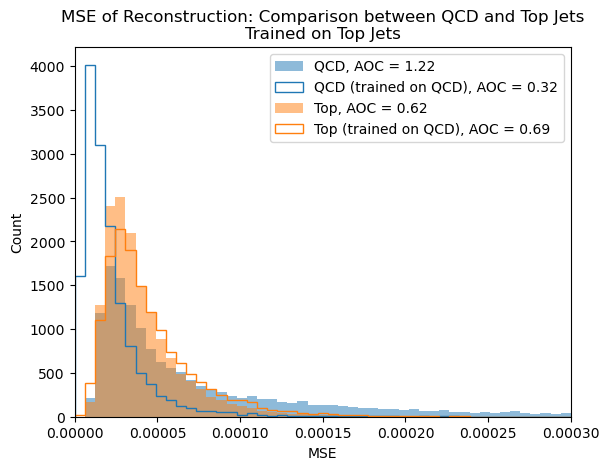

In [48]:
bins = np.linspace(0, 0.0003, 50)  # share bins for all histogram
plt.hist(
    qcd_mse_cnn_onlytop.detach().cpu(),
    bins=bins,
    alpha=0.5,
    label=f"QCD, AOC = {torch.sum(qcd_mse_cnn_onlytop):.2f}"
);
plt.hist(
    qcd_mse_cnn.detach().cpu(),
    histtype='step',
    color='C0',
    bins=bins,
    label=f"QCD (trained on QCD), AOC = {torch.sum(qcd_mse_cnn):.2f}"
);
plt.hist(
    top_mse_cnn_onlytop.detach().cpu(),
    bins=bins, 
    alpha=0.5, 
    label=f"Top, AOC = {torch.sum(top_mse_cnn_onlytop):.2f}"
);
plt.hist(
    top_mse_cnn.detach().cpu(),
    histtype='step',
    color='C1',
    bins=bins,
    label=f"Top (trained on QCD), AOC = {torch.sum(top_mse_cnn):.2f}"
);
plt.xlim(0, 0.0003)
plt.legend();
plt.xlabel("MSE")
plt.ylabel("Count")
plt.title("MSE of Reconstruction: Comparison between QCD and Top Jets\nTrained on Top Jets")

While the reconstruction quality of the top jets is marginally better for the model trained exclusively on top jets (total MSE of 0.62 compared to 0.69 for those trained on QCD), the reconstruction of QCD jets has gotten significantly worse. Even more importantly, looking at the histogram shows us that the curves of the QCD and Top reconstruction MSEs overlap almost completely. We can deduce that it will be extremely difficult to discriminate between the two types of jet using the MSE as a test statistic.

In [49]:
y_test_reconstruction = modelCNNonlytop(torch.Tensor(z_test))
y_test_mse = torch.mean(
    (torch.Tensor(z_test).squeeze() - y_test_reconstruction.squeeze())**2,
    dim=(1, 2)
)
y_test_mse = y_test_mse.detach().cpu().numpy()

In [50]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_mse)
auc_score = roc_auc_score(y_test, y_test_mse)

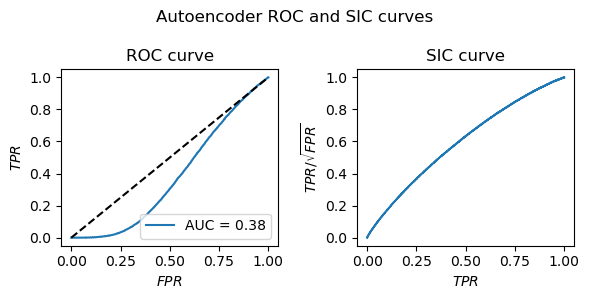

In [51]:
# create figure and two subplots
fig, ax = plt.subplots(1, 2, figsize=(6, 3))

# plot ROC curve
ax[0].plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
ax[0].plot([0, 1], [0, 1], "--", color="black")
ax[0].set_title("ROC curve")
ax[0].set_xlabel("$FPR$")
ax[0].set_ylabel("$TPR$")
ax[0].legend(loc='lower right')

# plot SIC curve
ax[1].plot(tpr[fpr != 0], tpr[fpr != 0]/np.sqrt(fpr[fpr != 0]))
ax[1].set_title("SIC curve")
ax[1].set_xlabel("$TPR$")
ax[1].set_ylabel("$TPR/\sqrt{{FPR}}$")

plt.suptitle("Autoencoder ROC and SIC curves")

plt.tight_layout()
plt.show()

We note that the CNN autoencoder trained only on top jets is not a good model for the detection of anomalies (i.e. QCD jets, which were not seen in training). The results of the ROC curve confirm our predictions made when viewing the MSE histograms: it is very difficult to accurately classify a jet as an anomaly or regular event based on the MSE. This can be seen when viewing the $AUC$, which lies at $0.38$. Hence it is very close the worst possible value in binary classification, which is $0.5$. The sensitivity is only high when accepting large false positive rates.

This is a surprising result, since the same CNN model when trained on QCD jets will yield $AUC = 0.80$. We assume that this is the case because top jets have less learnable structure than the QCD jets, meaning that there is less information which the model can learn during training.